In [1]:
# Ucitavanje potrebnih biblioteka

import numpy as np 
import pandas as pd 
import zipfile
import os
import random
import matplotlib.pyplot as plt
import shutil
from tqdm import tqdm 
from skimage.io import imread, imshow
from skimage.transform import resize
from pathlib import Path

from sklearn.metrics import accuracy_score
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Add, Dense, Dropout, Activation, ZeroPadding2D, BatchNormalization, Concatenate, Flatten, Conv2D, AveragePooling2D, MaxPool2D, Reshape, Conv2DTranspose
from tensorflow.keras.optimizers import Adam

import cv2
from sklearn.model_selection import train_test_split 

In [153]:
def load_data(data = None, folder_path=None, shape = 128):
    img_names = os.listdir(folder_path)
    
    names = []
    maskNames = []
    unames = []
    
    for i in range(len(img_names)):
        unames.append(img_names[i].split(')')[0])
    
    unames = list(set(unames))
    
    for i in range(len(unames)):
        names.append(unames[i]+').png')
        maskNames.append(unames[i]+')_mask.png')
    
    for i in range (len(names)):
        img = plt.imread(folder_path + '/' + names[i])
        mask = plt.imread(folder_path + '/' + maskNames[i])
        
        img = cv2.resize(img, (shape, shape)) 
        mask = cv2.resize(mask, (shape, shape))
        if mask.shape[-1] == 3:
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        
        data['img'].append(img)
        data['mask'].append(mask)


    print(np.array(data['img']).shape)        
    return data

In [154]:
train_data = {'img' : [],
           'mask' : []
          }

train_data = load_data(train_data, folder_path='Dataset_BUSI_with_GT/benign')
train_data = load_data(train_data, folder_path='Dataset_BUSI_with_GT/malignant')
train_data = load_data(train_data, folder_path='Dataset_BUSI_with_GT/normal')

(437, 128, 128, 3)
(647, 128, 128, 3)
(780, 128, 128, 3)


Prikaz primera iz baze podataka

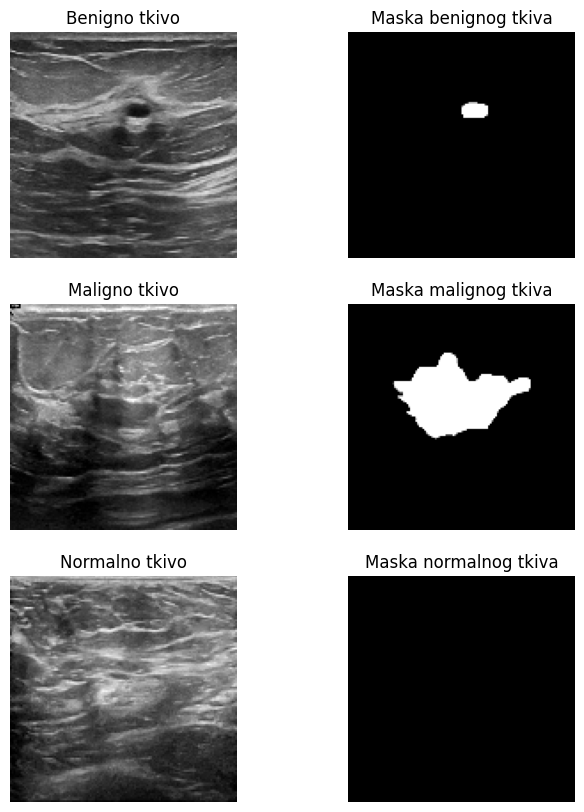

In [156]:
plt.figure(figsize=(8,10))
plt.subplot(3,2,1), plt.imshow(train_data['img'][54]), plt.title('Benigno tkivo'), plt.axis('off')
plt.subplot(3,2,2), plt.imshow(train_data['mask'][54], 'gray'), plt.title('Maska benignog tkiva'), plt.axis('off')
plt.subplot(3,2,3), plt.imshow(train_data['img'][509]), plt.title('Maligno tkivo'), plt.axis('off')
plt.subplot(3,2,4), plt.imshow(train_data['mask'][509], 'gray'), plt.title('Maska malignog tkiva'), plt.axis('off')
plt.subplot(3,2,5), plt.imshow(train_data['img'][647]), plt.title('Normalno tkivo'), plt.axis('off')
plt.subplot(3,2,6), plt.imshow(train_data['mask'][647], 'gray'), plt.title('Maska normalnog tkiva'), plt.axis('off')
plt.show()

In [160]:
def Conv2DBlock(inputTensor, numFilters, kernelSize = 3, do_batch_norm = True):
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (inputTensor)
    
    if do_batch_norm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x =tf.keras.layers.Activation('relu')(x)
    
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    if do_batch_norm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Activation('relu')(x)
                            
    return x

In [169]:
def EncoderMiniBlock(inputTensor, numFilters, kernelSize = 3, do_batch_norm = True):
    x = Conv2DBlock(inputTensor, numFilters, kernelSize, do_batch_norm)
    p = tf.keras.layers.MaxPooling2D((2, 2))(x)
    
    return x, p

In [170]:
def DecoderMiniBlock(inputTensor, skipTensor, numFilters, kernelSize = 3, do_batch_norm = True, dropout = 0.0):
    x = tf.keras.layers.Conv2DTranspose(numFilters, (3, 3), strides = 2, padding = 'same')(inputTensor)
    x = tf.keras.layers.concatenate([x, skipTensor])
    x = tf.keras.layers.Dropout(dropout)(x)
    x = Conv2DBlock(x, numFilters, kernelSize, do_batch_norm)
    
    return x

In [173]:
def UNetModel(inputImage, numFilters = 16, droupouts = 0.1, do_batch_norm = True):

    c1, p1 = EncoderMiniBlock(inputImage, numFilters, kernelSize = 3, do_batch_norm = do_batch_norm)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)
    
    c2, p2 = EncoderMiniBlock(p1, numFilters * 2, kernelSize = 3, do_batch_norm = do_batch_norm)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)
    
    c3, p3 = EncoderMiniBlock(p2, numFilters * 4, kernelSize = 3, do_batch_norm = do_batch_norm)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)
    
    c4, p4 = EncoderMiniBlock(p3, numFilters * 8, kernelSize = 3, do_batch_norm = do_batch_norm)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)
    
    c5 = Conv2DBlock(p4, numFilters * 16, kernelSize = 3, do_batch_norm = do_batch_norm)

    c6 = DecoderMiniBlock(c5, c4, numFilters * 8, kernelSize = 3, do_batch_norm = do_batch_norm, dropout = droupouts)
    c7 = DecoderMiniBlock(c6, c3, numFilters * 4, kernelSize = 3, do_batch_norm = do_batch_norm, dropout = droupouts)
    c8 = DecoderMiniBlock(c7, c2, numFilters * 2, kernelSize = 3, do_batch_norm = do_batch_norm, dropout = droupouts)
    c9 = DecoderMiniBlock(c8, c1, numFilters * 1, kernelSize = 3, do_batch_norm = do_batch_norm, dropout = droupouts)
    
    output = tf.keras.layers.Conv2D(1, (1, 1), activation = 'sigmoid')(c9)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    return model

In [174]:
modelUNet = UNetModel(tf.keras.layers.Input((128, 128, 3)))
modelUNet.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )
callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, monitor="val_loss")]

print(np.array(train_data['img']).shape, np.array(train_data['mask']).shape, np.array(train_data['img']).shape)

X_train, X_val, Y_train, Y_val = train_test_split(np.array(train_data['img']), np.array(train_data['mask']), test_size=0.1, random_state=42)
results = modelUNet.fit(X_train, Y_train, validation_split=0.1, epochs=50)


(780, 128, 128, 3) (780, 128, 128) (780, 128, 128, 3)
Epoch 1/50
20/20 [==============================] - 8s 191ms/step - loss: 0.7095 - accuracy: 0.6175 - val_loss: 12.8182 - val_accuracy: 0.0726
Epoch 2/50
20/20 [==============================] - 3s 157ms/step - loss: 0.4861 - accuracy: 0.9138 - val_loss: 3.8346 - val_accuracy: 0.4942
Epoch 3/50
20/20 [==============================] - 3s 155ms/step - loss: 0.4242 - accuracy: 0.9230 - val_loss: 0.4959 - val_accuracy: 0.9280
Epoch 4/50
20/20 [==============================] - 3s 156ms/step - loss: 0.3814 - accuracy: 0.9298 - val_loss: 1.2814 - val_accuracy: 0.8280
Epoch 5/50
20/20 [==============================] - 3s 157ms/step - loss: 0.3490 - accuracy: 0.9337 - val_loss: 2.9459 - val_accuracy: 0.6044
Epoch 6/50
20/20 [==============================] - 3s 157ms/step - loss: 0.3134 - accuracy: 0.9419 - val_loss: 0.7398 - val_accuracy: 0.7082
Epoch 7/50
20/20 [==============================] - 3s 157ms/step - loss: 0.2920 - accuracy: 

In [149]:
Y_pred = np.round(modelUNet.predict(X_val))
Y_val = np.round(Y_val)

accuracy_score(Y_val.flatten(), Y_pred.flatten())

3/3 [==============================] - 0s 131ms/step


0.9366447253104968

In [ ]:
learning_rate = [0.0001, 0.001, 0.01, 0.1]
train_val_history = []
Y_pred_all = []

for lr in learning_rate:
    modelUNet = UNetModel((128, 128, 3), lr)
    callbacks = [tf.keras.callbacks.EarlyStopping(patience=2, monitor="val_accuracy")]
    results = modelUNet.fit(X_train, Y_train, validation_split=0.1, batch_size=64, epochs=25, callbacks=callbacks)
    
    Y_pred = np.round(modelUNet.predict(X_test))
    
    y1 = Y_pred.flatten()
    y2 = Y_test.flatten()
    print('---------------')
    print(accuracy_score(y1, y2))
    print('---------------')
    
    train_val_history.append(results.history)
    Y_pred_all.append(Y_pred)

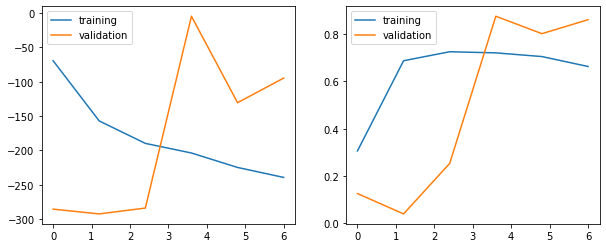

In [214]:
# lr = 0.0001
num = 0
x = len(train_val_history[num]['loss'])

plt.figure(figsize = (10,4))
plt.subplot(1,2,1)
plt.plot(np.linspace(0,x,x), train_val_history[num]['loss'])
plt.plot(np.linspace(0,x,x), train_val_history[num]['val_loss'])
plt.legend(['training', 'validation'])
plt.subplot(1,2,2)
plt.plot(np.linspace(0,x,x), train_val_history[num]['accuracy'])
plt.plot(np.linspace(0,x,x), train_val_history[num]['val_accuracy'])
plt.legend(['training', 'validation'])
plt.show()

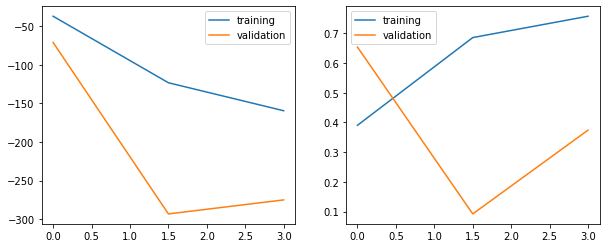

In [215]:
# lr = 0.001
num = 1
x = len(train_val_history[num]['loss'])

plt.figure(figsize = (10,4))
plt.subplot(1,2,1)
plt.plot(np.linspace(0,x,x), train_val_history[num]['loss'])
plt.plot(np.linspace(0,x,x), train_val_history[num]['val_loss'])
plt.legend(['training', 'validation'])
plt.subplot(1,2,2)
plt.plot(np.linspace(0,x,x), train_val_history[num]['accuracy'])
plt.plot(np.linspace(0,x,x), train_val_history[num]['val_accuracy'])
plt.legend(['training', 'validation'])
plt.show()

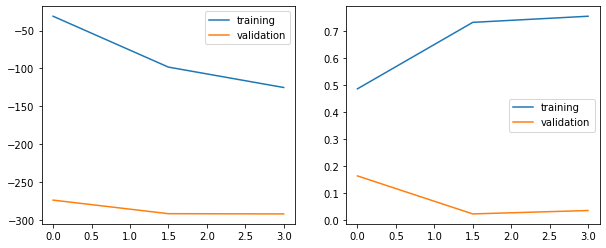

In [216]:
# lr = 0.01
num = 2
x = len(train_val_history[num]['loss'])

plt.figure(figsize = (10,4))
plt.subplot(1,2,1)
plt.plot(np.linspace(0,x,x), train_val_history[num]['loss'])
plt.plot(np.linspace(0,x,x), train_val_history[num]['val_loss'])
plt.legend(['training', 'validation'])
plt.subplot(1,2,2)
plt.plot(np.linspace(0,x,x), train_val_history[num]['accuracy'])
plt.plot(np.linspace(0,x,x), train_val_history[num]['val_accuracy'])
plt.legend(['training', 'validation'])
plt.show()

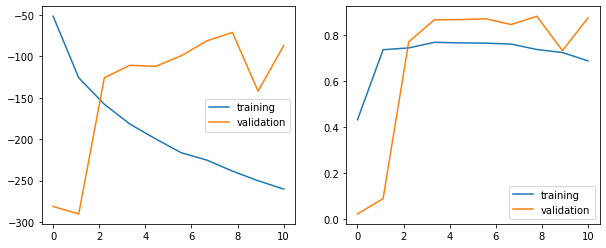

In [217]:
# lr = 0.1
num = 3
x = len(train_val_history[num]['loss'])

plt.figure(figsize = (10,4))
plt.subplot(1,2,1)
plt.plot(np.linspace(0,x,x), train_val_history[num]['loss'])
plt.plot(np.linspace(0,x,x), train_val_history[num]['val_loss'])
plt.legend(['training', 'validation'])
plt.subplot(1,2,2)
plt.plot(np.linspace(0,x,x), train_val_history[num]['accuracy'])
plt.plot(np.linspace(0,x,x), train_val_history[num]['val_accuracy'])
plt.legend(['training', 'validation'])
plt.show()